In [227]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
#import lightgbm
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
#import optuna
from sklearn.feature_selection import mutual_info_classif
#from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
#from optuna.samplers import TPESampler
#from optuna.integration import XGBoostPruningCallback,LightGBMPruningCallback
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, TimeSeriesSplit, cross_validate
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,make_scorer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('train_set.csv')
df['Fight_ID']
'''for index, row in df.iterrows():
    df_anteriores = df.iloc[0:index]
    df_anteriores_inverso = df_anteriores.iloc[::-1]
    contador_a = 1
    contador_b = 1
    for index2,row2 in df_anteriores_inverso.iterrows():
        if row2['Fighter_A_Name'] == row['Fighter_A_Name']:
            if ['Fighter_A_Is_Debut']==1:
            row[f'fa_lag{contador']==row['Winner_A']
            fa = True
'''                

"for index, row in df.iterrows():\n    df_anteriores = df.iloc[0:index]\n    df_anteriores_inverso = df_anteriores.iloc[::-1]\n    contador_a = 1\n    contador_b = 1\n    for index2,row2 in df_anteriores_inverso.iterrows():\n        if row2['Fighter_A_Name'] == row['Fighter_A_Name']:\n            if ['Fighter_A_Is_Debut']==1:\n            row[f'fa_lag{contador']==row['Winner_A']\n            fa = True\n"

In [331]:
df = pd.read_csv('train_set.csv')
#df = df.iloc[4923:]
#df.drop(df[df['Weight_Class'].isin(['Catch Weight', 'Other'])].index, inplace=True)
#df[df['Weight_Class'] == 'Catch Weight']
#df[df['Weight_Class'] == 'Other']
#df.drop(df[df['Weight_Class'].isin(['Catch Weight', 'Other'])].index, inplace=True)
df.drop(['Fighter_A_Name', 'Fighter_B_Name', 'Date',
         'Referee', 'Location', 'Country', 'Continent', 'Season', 'Fight_ID'], axis=1, inplace=True)
#features_a_quitar=['Fighter_B_Sig_Str_Landed_Body', 'Fighter_A_Sig_Str_Landed_Body', 'Fighter_A_Totals_Rev', 'Fighter_B_Totals_Rev', 'Fighter_B_Is_Debut', 'Fighter_A_Is_Debut', 'Fighter_B_Sig_Str_Attempted_Leg', 'Fighter_A_Sig_Str_Attempted_Leg', 'Fighter_A_Is_Debut', 'Fighter_B_Is_Debut', 'Fighter_B_Draws', 'Fighter_A_Draws', 'Fighter_A_Draws', 'Fighter_B_Draws', 'Fighter_A_Sig_Str_Landed_Body', 'Fighter_B_Sig_Str_Landed_Body', 'Fighter_B_Sig_Str_Attempted_Clinch', 'Fighter_A_Sig_Str_Attempted_Clinch', 'Fighter_B_Totals_Rev', 'Fighter_A_Totals_Rev', 'Fighter_A_Sig_Str_Attempted_Clinch', 'Fighter_B_Sig_Str_Attempted_Clinch', 'Fighter_A_Sig_Str_Attempted_Leg', 'Fighter_B_Sig_Str_Attempted_Leg']
#df.drop(inplace=True, columns=features_a_quitar)
df = df[(df["Fighter_A_Is_Debut"] != 1) | (df["Fighter_B_Is_Debut"] != 1)]
y = df['Winner_A']
df2 = df.copy()
df2.drop(['Winner_A'], inplace = True, axis = 1)
df.drop(['Winner_A'], inplace = True, axis = 1)

'''X_2 = []
df2.drop('Winner_A', axis=1, inplace =True)
for i in df2.columns:
    if i[10:] not in X_2:
        X_2.append(i[10:])

X_2
df2.columns'''

#Calcular el porcentaje de victorias, perdidas y empates. Y quitar el absoluto de estos
letras = ['A','B']
caracteristicas = ['Wins','Losses','Draws']
caracteristicas_2 = ['Body','Head','Leg','Clinch','Distance','Ground']
#'Sig_Str_Landed', 'Sig_Str_Attempted'
#'Totals_Str_Landed', 'Totals_Str_Attempted'
for l in letras:
    for c in caracteristicas:
        df[f'Fighter_{l}_Percentage_{c}'] = np.where(df[f'Fighter_{l}_Total_Fights'] != 0, 
                                           df[f'Fighter_{l}_{c}']+1 / df[f'Fighter_{l}_Total_Fights']+1, -1)
                                                  
        df.drop(columns=[f'Fighter_{l}_{c}'], inplace=True)
    for c2 in caracteristicas_2:
        df[f'Fighter_{l}_Sig_Str_Landed/Attempted_{c2}'] = np.where(df[f'Fighter_{l}_Sig_Str_Attempted_{c2}'] != 0, 
                                           df[f'Fighter_{l}_Sig_Str_Landed_{c2}']+1 / df[f'Fighter_{l}_Sig_Str_Attempted_{c2}']+1, 0)
        df.drop(columns=[f'Fighter_{l}_Sig_Str_Landed_{c2}'], inplace=True)
        df.drop(columns=[f'Fighter_{l}_Sig_Str_Attempted_{c2}'], inplace=True)

    df[f'Fighter_{l}_Sig_Str_Landed/Attempted_Global'] = np.where(df[f'Fighter_{l}_Sig_Str_Attempted'] != 0, 
                                           df[f'Fighter_{l}_Sig_Str_Landed']+1 / df[f'Fighter_{l}_Sig_Str_Attempted']+1, 0) #Le sumo uno a cada uno para aplicar suavizado, aunque en este caso no se si haria falta
    df.drop(columns=[f'Fighter_{l}_Sig_Str_Landed'], inplace=True)
    df.drop(columns=[f'Fighter_{l}_Sig_Str_Attempted'], inplace=True)

    '''df[f'Fighter_{l}_Totals_Str_Landed/Attempted'] = np.where(df[f'Fighter_{l}_Totals_Str_Attempted'] != 0, 
                                           df[f'Fighter_{l}_Totals_Str_Landed'] / df[f'Fighter_{l}_Totals_Str_Attempted']+1, -1)
    df.drop(columns=[f'Fighter_{l}_Totals_Str_Landed'], inplace=True)
    df.drop(columns=[f'Fighter_{l}_Totals_Str_Attempted'], inplace=True)'''

#Quitamos donde debutan ambos
features = df.drop(columns=['Fighter_A_Is_Debut', 'Fighter_B_Is_Debut','Title_Bout','Weight_Class']).columns.tolist()
features_2 = []
for f in features:
    if f[10:] not in features_2:
        features_2.append(f[10:])

print(features_2)
for feat in features_2:
    col_a = f"Fighter_A_{feat}"
    col_b = f"Fighter_B_{feat}"
    ratio_col = f"A/B_{feat}"
    #Probé con la diferencia pero el ratio funciona mejor
    # Evitar divisiones por 0 o valores faltantes
    df[ratio_col] = np.where(df[col_b] != 0, df[col_a] / df[col_b], -1)
# Opcional: reemplazar NaN o inf
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

#df.fillna(0, inplace=True)
df.filter(like="Fighter_A").columns


['Totals_KD', 'Totals_Rev', 'Totals_Sub_att', 'Totals_Td_Pct', 'Totals_Str_Landed', 'Totals_Str_Attempted', 'Totals_Ctrl_Sec', 'Total_Fights', 'Win_Streak', 'Lose_Streak', 'Experience_Years', 'Days_Since_Last_Fight', 'Percentage_Wins', 'Percentage_Losses', 'Percentage_Draws', 'Sig_Str_Landed/Attempted_Body', 'Sig_Str_Landed/Attempted_Head', 'Sig_Str_Landed/Attempted_Leg', 'Sig_Str_Landed/Attempted_Clinch', 'Sig_Str_Landed/Attempted_Distance', 'Sig_Str_Landed/Attempted_Ground', 'Sig_Str_Landed/Attempted_Global']


Index(['Fighter_A_Totals_KD', 'Fighter_A_Totals_Rev',
       'Fighter_A_Totals_Sub_att', 'Fighter_A_Totals_Td_Pct',
       'Fighter_A_Totals_Str_Landed', 'Fighter_A_Totals_Str_Attempted',
       'Fighter_A_Totals_Ctrl_Sec', 'Fighter_A_Total_Fights',
       'Fighter_A_Win_Streak', 'Fighter_A_Lose_Streak',
       'Fighter_A_Experience_Years', 'Fighter_A_Days_Since_Last_Fight',
       'Fighter_A_Is_Debut', 'Fighter_A_Percentage_Wins',
       'Fighter_A_Percentage_Losses', 'Fighter_A_Percentage_Draws',
       'Fighter_A_Sig_Str_Landed/Attempted_Body',
       'Fighter_A_Sig_Str_Landed/Attempted_Head',
       'Fighter_A_Sig_Str_Landed/Attempted_Leg',
       'Fighter_A_Sig_Str_Landed/Attempted_Clinch',
       'Fighter_A_Sig_Str_Landed/Attempted_Distance',
       'Fighter_A_Sig_Str_Landed/Attempted_Ground',
       'Fighter_A_Sig_Str_Landed/Attempted_Global'],
      dtype='object')

In [333]:
#df_d = df.filter(like="Diff_").copy()

df_r = df.filter(like="A/B_").copy()



df_r.drop(['A/B_Totals_Sub_att','A/B_Totals_KD','A/B_Lose_Streak','A/B_Totals_Rev'],inplace=True,axis=1)

'''X_train = df_r.iloc[:5000]
X_val = df_r.iloc[5000:]
y_train = y.iloc[:5000]
y_val = y.iloc[5000:]
y.shape
df_r'''

'X_train = df_r.iloc[:5000]\nX_val = df_r.iloc[5000:]\ny_train = y.iloc[:5000]\ny_val = y.iloc[5000:]\ny.shape\ndf_r'

In [249]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_r)
kmeans = KMeans(n_clusters=3, random_state=42)  # Cambia n_clusters a lo que necesites

# Ajustar el modelo y predecir las etiquetas de clúster
df_r['cluster'] = kmeans.fit_predict(X_scaled)



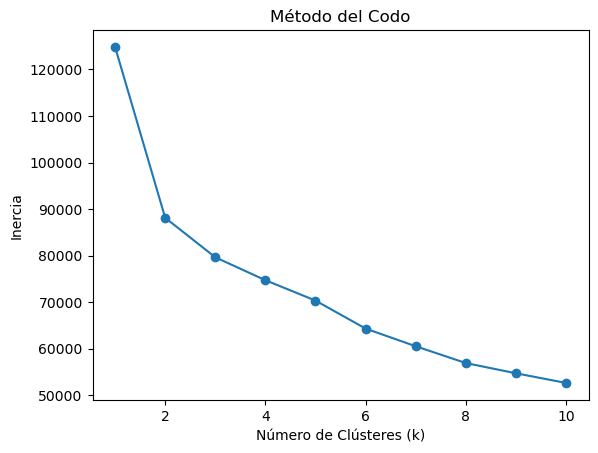

In [233]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

In [255]:
df_r.drop(['cluster'], inplace=True,axis=1)

In [257]:
scores = cross_val_score(rf_model, df_r,y, scoring='f1_weighted',cv=skf,n_jobs=-1)
print (scores.mean())

0.5678076512288841


In [305]:
xgb_model = XGBClassifier(random_state=0,n_estimators=550)
rf_model = RandomForestClassifier(random_state=0,n_estimators=400)

base_learners = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    #('svm', SVC(kernel='sigmoid', C=2,random_state=42))
]

# Definir el meta-modelo
meta_model = LogisticRegression()

# Crear el StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# Entrenar el modelo
tscv = TimeSeriesSplit(n_splits=10)
#scores = cross_val_score(stacking_model, df_r,y, scoring='f1_weighted', cv=tscv)
# Hacer predicciones
print(scores.mean())

0.5678076512288841


In [215]:
skf = StratifiedKFold(n_splits=5)
def ajh (valor):
    xgb_model = XGBClassifier(random_state=0,n_estimators=550)
    rf_model = RandomForestClassifier(random_state=0,n_estimators=400)
    
    base_learners = [
        ('rf', rf_model),
        ('xgb', xgb_model),
        #('svm', SVC(kernel='sigmoid', C=2,random_state=42))
    ]
    
    # Definir el meta-modelo
    meta_model = LogisticRegression(max_iter=1000, C=valor)
    
    # Crear el StackingClassifier
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)
    scores = cross_val_score(stacking_model, df_r,y, scoring='f1_weighted',cv=skf,n_jobs=-1)
    return scores.mean()
    
d={}

In [220]:
#import matplotlib.pyplot as plt

for i in np.arange(0.1, 10.1, 1.1):
    d[i]=ajh(i)

KeyboardInterrupt: 

,A/B_Totals_Td_Pct,A/B_Totals_Str_Landed,A/B_Totals_Str_Attempted,A/B_Totals_Ctrl_Sec,A/B_Total_Fights,A/B_Win_Streak,A/B_Experience_Years,A/B_Days_Since_Last_Fight,A/B_Percentage_Wins,A/B_Percentage_Losses,A/B_Percentage_Draws,A/B_Sig_Str_Landed/Attempted_Body,A/B_Sig_Str_Landed/Attempted_Head,A/B_Sig_Str_Landed/Attempted_Leg,A/B_Sig_Str_Landed/Attempted_Clinch,A/B_Sig_Str_Landed/Attempted_Distance,A/B_Sig_Str_Landed/Attempted_Ground,A/B_Sig_Str_Landed/Attempted_Global
0,0.000000,0.419355,0.528107,0.011589,0.285714,-1.0,0.303571,0.777778,0.486111,0.603448,1.312500,0.313674,0.568949,1.109088,0.880826,0.576845,1.225000,0.534966
1,0.500000,1.178571,1.503546,1.864865,1.000000,-1.0,1.130112,1.000000,1.247423,0.671233,1.000000,1.938599,1.180337,0.741935,0.830646,1.645092,0.707372,1.227458
2,3.060159,0.792462,0.688594,4.584613,3.230769,1.0,1.663180,0.432432,3.221995,2.546843,0.950680,0.630214,0.738654,0.590597,1.419352,0.521009,0.802191,0.626148
3,0.816459,0.822078,0.801484,1.556800,1.222222,0.0,1.150000,1.761905,1.120797,1.314935,0.981818,0.776841,0.887778,0.762703,0.949229,0.690470,1.153894,0.787962
4,-1.000000,0.855556,0.722000,1.776923,10.000000,0.0,19.176871,1.600000,5.652941,8.011111,0.820000,0.480740,0.766418,1.318731,1.005273,0.659641,-1.000000,0.735162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
961,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
962,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
963,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [325]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Cambia n_clusters a lo que necesites
scaler = StandardScaler()
# Ajustar (fit) el escalador y transformar (transform) DF_R
df_r_scaled = scaler.fit_transform(df_r)
# Ajustar (fit) K-Means y predecir en DF_R (aprende los centroides en DF_R)
df_r['cluster'] = kmeans.fit_predict(df_r_scaled)

## 2. PREDICCIÓN EN EL CONJUNTO DE PRUEBA (DF_TEST) - ¡SIN FIT!

# Solo transformar (transform) DF_TEST con la media/std de DF_R
df_test_scaled = scaler.transform(df_test) 
# Solo predecir (predict) DF_TEST usando los centroides aprendidos de DF_R
df_test['cluster'] = kmeans.predict(df_test_scaled)

In [335]:
df_r

,A/B_Totals_Td_Pct,A/B_Totals_Str_Landed,A/B_Totals_Str_Attempted,A/B_Totals_Ctrl_Sec,A/B_Total_Fights,A/B_Win_Streak,A/B_Experience_Years,A/B_Days_Since_Last_Fight,A/B_Percentage_Wins,A/B_Percentage_Losses,A/B_Percentage_Draws,A/B_Sig_Str_Landed/Attempted_Body,A/B_Sig_Str_Landed/Attempted_Head,A/B_Sig_Str_Landed/Attempted_Leg,A/B_Sig_Str_Landed/Attempted_Clinch,A/B_Sig_Str_Landed/Attempted_Distance,A/B_Sig_Str_Landed/Attempted_Ground,A/B_Sig_Str_Landed/Attempted_Global
17,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-5.250000,-1.250000,-1.250000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
21,-1.00000,0.766667,0.561538,-1.000000,5.000000,5.0,2.857143,1.000000,2.066667,0.600000,0.600000,-1.000000,0.101591,0.391129,0.694286,0.371930,0.120873,0.084442
22,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-6.200000,-1.200000,-1.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-3.000000,-2.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
27,0.00000,0.000000,0.000000,-1.000000,0.000000,0.0,0.000000,0.000000,-0.161290,-0.833333,-0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7430,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.190476,-0.800000,-0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
7431,0.00000,0.570825,0.515734,0.000000,0.100000,-1.0,0.150943,1.238095,0.226244,0.226244,1.428571,1.067870,0.229042,1.437500,0.000000,0.629760,0.000000,0.541202
7432,2.12782,1.436620,1.012048,1.682073,2.000000,4.0,1.060241,0.327586,1.441176,1.833333,0.900000,0.867647,0.758260,1.242284,1.131696,0.582643,1.843681,0.814218
7433,-1.00000,1.805447,1.705051,2.176000,0.500000,0.0,0.574219,1.625000,0.852459,0.360656,1.090909,0.961611,3.206349,1.638712,0.849187,2.499023,1.838961,2.277602


In [343]:
rf_model.fit(df_r,y)
predictions = rf_model.predict(df_test)
results = pd.DataFrame({
    'Fight_ID': ids,  # o X_test.index si no tienes una columna 'id'
    'Winner': predictions
})

results.to_csv('submission.csv', index=False)

print("Archivo 'submission.csv' creado exitosamente.")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Archivo 'submission.csv' creado exitosamente.


In [339]:
def preprocesar():
    df = pd.read_csv('test_set.csv')
    ids = df['Fight_ID']
    df.drop(['Fighter_A_Name', 'Fighter_B_Name', 'Date',
             'Referee', 'Location', 'Country', 'Continent', 'Season','Fight_ID'], axis=1, inplace=True)
    
    letras = ['A','B']
    caracteristicas = ['Wins','Losses','Draws']
    caracteristicas_2 = ['Body','Head','Leg','Clinch','Distance','Ground']
    
    for l in letras:
        for c in caracteristicas:
            df[f'Fighter_{l}_Percentage_{c}'] = np.where(df[f'Fighter_{l}_Total_Fights'] != 0, 
                                               df[f'Fighter_{l}_{c}']+1 / df[f'Fighter_{l}_Total_Fights']+1, -1)
                                                      
            df.drop(columns=[f'Fighter_{l}_{c}'], inplace=True)
        for c2 in caracteristicas_2:
            df[f'Fighter_{l}_Sig_Str_Landed/Attempted_{c2}'] = np.where(df[f'Fighter_{l}_Sig_Str_Attempted_{c2}'] != 0, 
                                               df[f'Fighter_{l}_Sig_Str_Landed_{c2}']+1 / df[f'Fighter_{l}_Sig_Str_Attempted_{c2}']+1, 0)
            df.drop(columns=[f'Fighter_{l}_Sig_Str_Landed_{c2}'], inplace=True)
            df.drop(columns=[f'Fighter_{l}_Sig_Str_Attempted_{c2}'], inplace=True)
    
        df[f'Fighter_{l}_Sig_Str_Landed/Attempted_Global'] = np.where(df[f'Fighter_{l}_Sig_Str_Attempted'] != 0, 
                                               df[f'Fighter_{l}_Sig_Str_Landed']+1 / df[f'Fighter_{l}_Sig_Str_Attempted']+1, 0) #Le sumo uno a cada uno para aplicar suavizado, aunque en este caso no se si haria falta
        df.drop(columns=[f'Fighter_{l}_Sig_Str_Landed'], inplace=True)
        df.drop(columns=[f'Fighter_{l}_Sig_Str_Attempted'], inplace=True)
    
        '''df[f'Fighter_{l}_Totals_Str_Landed/Attempted'] = np.where(df[f'Fighter_{l}_Totals_Str_Attempted'] != 0, 
                                               df[f'Fighter_{l}_Totals_Str_Landed'] / df[f'Fighter_{l}_Totals_Str_Attempted']+1, -1)
        df.drop(columns=[f'Fighter_{l}_Totals_Str_Landed'], inplace=True)
        df.drop(columns=[f'Fighter_{l}_Totals_Str_Attempted'], inplace=True)'''
    
    
    features = df.drop(columns=['Fighter_A_Is_Debut', 'Fighter_B_Is_Debut','Title_Bout','Weight_Class']).columns.tolist()
    features_2 = []
    for f in features:
        if f[10:] not in features_2:
            features_2.append(f[10:])
    
    print(features_2)
    for feat in features_2:
        col_a = f"Fighter_A_{feat}"
        col_b = f"Fighter_B_{feat}"
        ratio_col = f"A/B_{feat}"
        #Probé con la diferencia pero el ratio funciona mejor
        # Evitar divisiones por 0 o valores faltantes
        df[ratio_col] = np.where(df[col_b] != 0, df[col_a] / df[col_b], -1)
    # Opcional: reemplazar NaN o inf
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #df.fillna(0, inplace=True)
    
    df_r = df.filter(like="A/B_").copy()
    
    
    
    df_r.drop(['A/B_Totals_Sub_att','A/B_Totals_KD','A/B_Lose_Streak','A/B_Totals_Rev'],inplace=True,axis=1)
    return df_r, ids

In [341]:
df_test, ids = preprocesar()

['Totals_KD', 'Totals_Rev', 'Totals_Sub_att', 'Totals_Td_Pct', 'Totals_Str_Landed', 'Totals_Str_Attempted', 'Totals_Ctrl_Sec', 'Total_Fights', 'Win_Streak', 'Lose_Streak', 'Experience_Years', 'Days_Since_Last_Fight', 'Percentage_Wins', 'Percentage_Losses', 'Percentage_Draws', 'Sig_Str_Landed/Attempted_Body', 'Sig_Str_Landed/Attempted_Head', 'Sig_Str_Landed/Attempted_Leg', 'Sig_Str_Landed/Attempted_Clinch', 'Sig_Str_Landed/Attempted_Distance', 'Sig_Str_Landed/Attempted_Ground', 'Sig_Str_Landed/Attempted_Global']


In [49]:
df_test.columns

Index(['A/B_Totals_Td_Pct', 'A/B_Totals_Str_Landed',
       'A/B_Totals_Str_Attempted', 'A/B_Totals_Ctrl_Sec', 'A/B_Total_Fights',
       'A/B_Win_Streak', 'A/B_Experience_Years', 'A/B_Days_Since_Last_Fight',
       'A/B_Percentage_Wins', 'A/B_Percentage_Losses', 'A/B_Percentage_Draws',
       'A/B_Sig_Str_Landed/Attempted_Body',
       'A/B_Sig_Str_Landed/Attempted_Head', 'A/B_Sig_Str_Landed/Attempted_Leg',
       'A/B_Sig_Str_Landed/Attempted_Clinch',
       'A/B_Sig_Str_Landed/Attempted_Distance',
       'A/B_Sig_Str_Landed/Attempted_Ground',
       'A/B_Sig_Str_Landed/Attempted_Global'],
      dtype='object')

In [76]:
results = pd.DataFrame({
    'Fight_ID': ids,  # o X_test.index si no tienes una columna 'id'
    'Winner': predictions
})

results.to_csv('submission_2911.csv', index=False)

In [17]:
sw = calcular_sample_weights(df_r)